# Exploratory Data Analysis for the Transactions dataset

### Fraud detection - Transactions dataset

A sandbox for exploratory data analysis on the transactions dataset to identify fraudulent transactions

```Benjamin Jones```

Do a quick analysis to get a feel for what the data looks like. Focus here isn't to be robust or necessarily the most efficient, but to gain insights to drive our decisions later on. 



### Exec Summary:

We carried out a number of analyses on the dataset provided, including:
 * Profiling 
 * Correlation anaylsis 
 * Distribution analysis 
 * Time variance analysis 
 * In depth analysis of the relationship of several variables with the target class 
 
 
 ### Results
 
 By profiling, we identified several features of low (zero) variance, highly correlated features and high cardinality features.
 
 * ```transactionAmount``` has significantly different distributions for the two target classes, higher transaction amounts are more likely to be fraudulent. We expect this to be a key source of information for the model
 * A ```transactionAmount``` with £XX.00 ie 0p is nearly twice as likely to be non fraudulent as fraudulent
 * There's a relationship between chronological time and fraud - fraud occurences appear less often as time goes on in the dataset.
 * Fraud is broadly present across all countries with some variance
 * Fraud occurrences vary significantly by ```merchantName``` - this is expected to be a key source of information
 * Fraud occures twice as often when the CVV entered is not correct
 
### Additional analyses to consider with more time: 

There were many variables and relationships we have not explored but would like to, for example: the relationship between ```expirationDateKeyInMatch``` and isFraud, ```purchaseType```,  ```posEntryMode``` etc. 

Furthermore, we'd like to explore further the relationship between ```accountNumber``` and fraud - is the accountNumber significant, ie __are some accounts more likely than others?__ Assumed for the purposes of this task that each line item in the same account number was just as likely to be fraudulent as the last, though a quick frequency analysis shows a non-normal distribution of fraud % per account, which suggests this may be invalid).

Another point: should certain accountNumbers be more prone than others, the datetime delta between transaction events would be interesting - "is a fraudulent transation more likely to occur shortly after other transactions, or after an acceleration of transactions"?

On a similar note: __is fraud more likely if the country/state/location code is not the same as the location of the other transactions?__ 

In [1]:
import os
from pathlib import Path
import datetime
import math

import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt
import seaborn as sns

from src.notebook_utilities import calculate_target_percentage_by_group

plt.style.use('bmh')
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

### Load data 

In [ ]:
os.getcwd()

In [2]:
data_path = "../data/raw/transactions.txt"
Path.exists(Path(data_path))

True

In [3]:
df = pd.read_json(data_path, lines=True)

In [4]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch
0,733493772,733493772,5000,5000.00,2016-01-08T19:04:50,111.33,Lyft,US,US,05,01,rideshare,04/2020,2014-08-03,2014-08-03,492,492,9184,PURCHASE,True,,0.00,,,,False,,,False
1,733493772,733493772,5000,4888.67,2016-01-09T22:32:39,24.75,Uber,US,US,09,01,rideshare,06/2023,2014-08-03,2014-08-03,492,492,9184,PURCHASE,False,,111.33,,,,False,,,False
2,733493772,733493772,5000,4863.92,2016-01-11T13:36:55,187.40,Lyft,US,US,05,01,rideshare,12/2027,2014-08-03,2014-08-03,492,492,9184,PURCHASE,False,,136.08,,,,False,,,False
3,733493772,733493772,5000,4676.52,2016-01-11T22:47:46,227.34,Lyft,US,US,02,01,rideshare,09/2029,2014-08-03,2014-08-03,492,492,9184,PURCHASE,True,,323.48,,,,False,,,False
4,733493772,733493772,5000,4449.18,2016-01-16T01:41:11,0.00,Lyft,US,US,02,01,rideshare,10/2024,2014-08-03,2014-08-03,492,492,9184,ADDRESS_VERIFICATION,False,,550.82,,,,False,,,False


 * Many values here have blank entries. These are easier to handle by explicitly converting to NaNs since they'll show better in the summary statistics. 
 * We'll coerce the datetime to a proper datetime dtype also

In [6]:
# replace blanks with nan for reporting
df = df.replace(r'^\s*$', np.nan, regex=True)
# coerce date cols to the a useable format 
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])

df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,isFraud,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch
0,733493772,733493772,5000,5000.00,2016-01-08 19:04:50,111.33,Lyft,US,US,05,...,True,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False
1,733493772,733493772,5000,4888.67,2016-01-09 22:32:39,24.75,Uber,US,US,09,...,False,NaN,111.33,NaN,NaN,NaN,False,NaN,NaN,False
2,733493772,733493772,5000,4863.92,2016-01-11 13:36:55,187.40,Lyft,US,US,05,...,False,NaN,136.08,NaN,NaN,NaN,False,NaN,NaN,False
3,733493772,733493772,5000,4676.52,2016-01-11 22:47:46,227.34,Lyft,US,US,02,...,True,NaN,323.48,NaN,NaN,NaN,False,NaN,NaN,False
4,733493772,733493772,5000,4449.18,2016-01-16 01:41:11,0.00,Lyft,US,US,02,...,False,NaN,550.82,NaN,NaN,NaN,False,NaN,NaN,False


### Basic analysis

In [79]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641914 entries, 0 to 641913
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   accountNumber             641914 non-null  int64         
 1   customerId                641914 non-null  int64         
 2   creditLimit               641914 non-null  int64         
 3   availableMoney            641914 non-null  float64       
 4   transactionDateTime       641914 non-null  datetime64[ns]
 5   transactionAmount         641914 non-null  float64       
 6   merchantName              641914 non-null  object        
 7   acqCountry                638001 non-null  object        
 8   merchantCountryCode       641290 non-null  object        
 9   posEntryMode              638569 non-null  object        
 10  posConditionCode          641627 non-null  object        
 11  merchantCategoryCode      641914 non-null  object        
 12  cu

We can see here there are a few zero variance columns. We'll drop these

In [80]:
drop_cols = [column for column in df if df[column].count() / len(df) <= 0.1]  # NaN > 90% threshold gets dropped 
drop_cols

['echoBuffer',
 'merchantCity',
 'merchantState',
 'merchantZip',
 'posOnPremises',
 'recurringAuthInd']

In [81]:
df = df.drop(columns=drop_cols)
print(f'df.columns dropped: {drop_cols}\n')  
print(f'df.columns remaining: \n {df.columns.values}') 

df.columns dropped: ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd']

df.columns remaining: 
 ['accountNumber' 'customerId' 'creditLimit' 'availableMoney'
 'transactionDateTime' 'transactionAmount' 'merchantName' 'acqCountry'
 'merchantCountryCode' 'posEntryMode' 'posConditionCode'
 'merchantCategoryCode' 'currentExpDate' 'accountOpenDate'
 'dateOfLastAddressChange' 'cardCVV' 'enteredCVV' 'cardLast4Digits'
 'transactionType' 'isFraud' 'currentBalance' 'cardPresent'
 'expirationDateKeyInMatch']


In [82]:
df['isFraud'].value_counts()

False    630612
True      11302
Name: isFraud, dtype: int64

In [46]:
df['posEntryMode'].value_counts()

05    255615
09    193193
02    160589
90     16251
80     12921
Name: posEntryMode, dtype: int64

[!] Imbalanced dataset will require downsampling and careful performance metric selection  

In [45]:
df.describe(include='all')

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,isFraud,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch
count,6.419140e+05,6.419140e+05,641914.000000,641914.000000,641914,641914.000000,641914,638001,641290,638569,...,641914,0.0,641914.000000,0.0,0.0,0.0,641914,0.0,0.0,641914
unique,NaN,NaN,NaN,NaN,635472,NaN,2493,4,4,5,...,2,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,2
top,NaN,NaN,NaN,NaN,2016-01-11 00:34:57,NaN,Lyft,US,US,05,...,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,False
freq,NaN,NaN,NaN,NaN,3,NaN,25311,632303,635577,255615,...,630612,NaN,NaN,NaN,NaN,NaN,340453,NaN,NaN,640945
first,NaN,NaN,NaN,NaN,2016-01-01 00:00:37,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2016-12-30 23:59:27,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.547701e+08,5.547701e+08,10697.210608,6652.828573,NaN,135.162497,NaN,NaN,NaN,NaN,...,NaN,NaN,4044.382035,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2.546884e+08,2.546884e+08,11460.359133,9227.132275,NaN,147.053302,NaN,NaN,NaN,NaN,...,NaN,NaN,5945.510224,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.005471e+08,1.005471e+08,250.000000,-1244.930000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.223192e+08,3.223192e+08,5000.000000,1114.970000,NaN,32.320000,NaN,NaN,NaN,NaN,...,NaN,NaN,502.442500,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Pandas Profiling

Pandas profiling does a lot of the heavy lifting for you when you're looking for quick insights. Recommend viewing in the native html, but preview below. 

In [ ]:
# this step takes ~3 minutes on local hardware

# from pandas_profiling import ProfileReport
profile = ProfileReport(df, title='Pandas Profiling Report')
# profile.to_widgets()
# profile.to_notebook_iframe()
# profile.to_file("transactions_pandas_profiling.html")  # recommend viewing on the .html file, preview below

Results: 

 * isFraud weakly correlates with transactionAmount and posEntryMode
 * merchantName and accountOpenDate have very high cardinality
 * accountNumber is highly correlated with customerId
 * enteredCVV is highly correlated with cardCVV
 * cardCVV is highly correlated with enteredCVV
 * merchantCountryCode is highly correlated with acqCountry
 
 

### Targeted Analysis

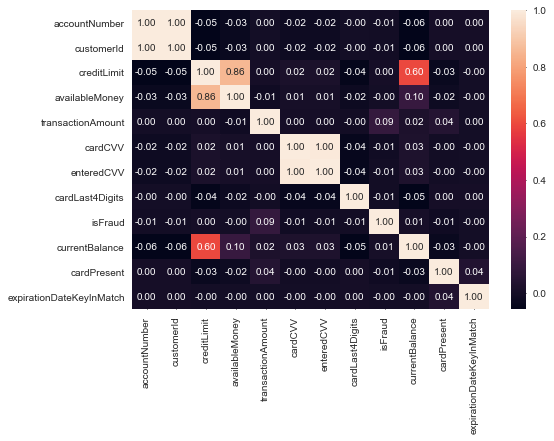

In [18]:
# plot a correlation plot to investigate linear relationships in the data
sns.heatmap(df.corr(), annot=True, fmt='.2f')

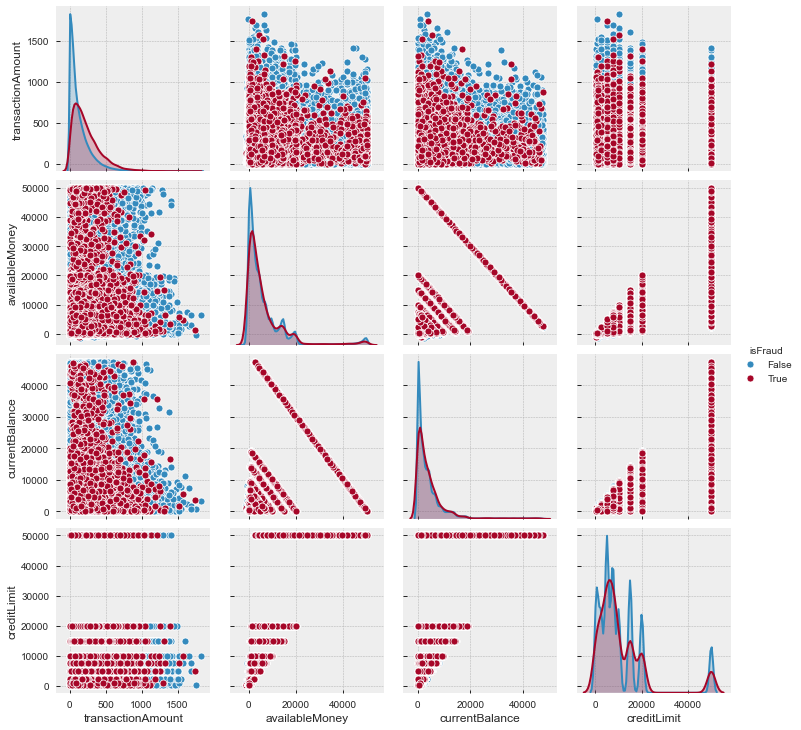

In [19]:
# plot continuous variables on a pairplot to investigate relationships between variables and target 
sns.pairplot(df, vars=['transactionAmount', 'availableMoney', 'currentBalance', 'creditLimit'], hue='isFraud')

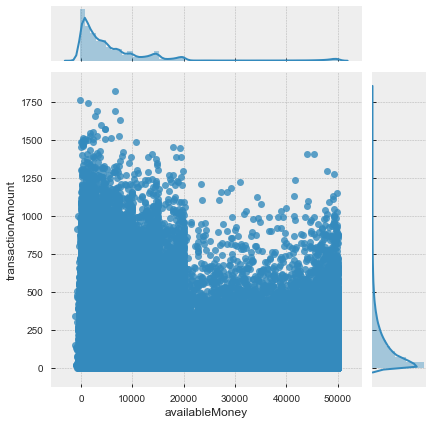

In [20]:
sns.jointplot("availableMoney", "transactionAmount", data=df, kind='reg')

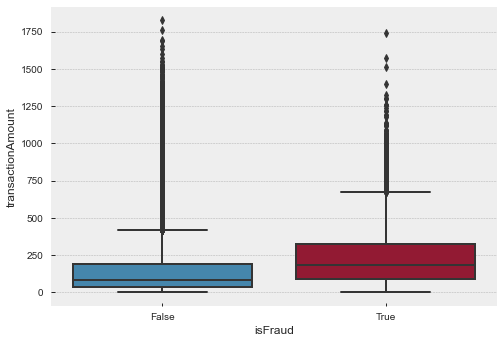

In [21]:
# see the distribution difference across the most highly correlated feature to the target 
ax = sns.boxplot(x='isFraud', y='transactionAmount', data=df)

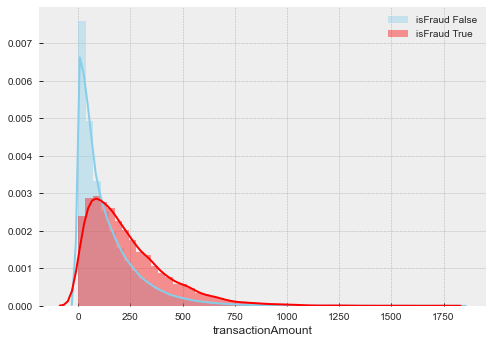

In [8]:
sns.distplot( df["transactionAmount"][df["isFraud"] == False] , color="skyblue", label="isFraud False")
sns.distplot( df["transactionAmount"][df["isFraud"] == True], color="red", label="isFraud True")
plt.legend()


From the corrplot and jointplot we are given a hint that there's information contained in transactionAmount for isFraud. The boxplot shows the distributions are clearly distinct

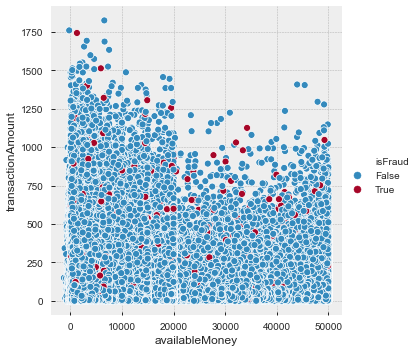

In [22]:
sns.relplot(x="availableMoney", y="transactionAmount", hue="isFraud", data=df)

Checking to see if there's any obvious relationship between fraud, transactionAmount and availableMoney. Nothing obvious

### Check variance over time 

Does the percentage of fraudulent transactions vary over time? 

In [23]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch
0,733493772,733493772,5000,5000.00,2016-01-08 19:04:50,111.33,Lyft,US,US,05,...,2014-08-03,2014-08-03,492,492,9184,PURCHASE,True,0.00,False,False
1,733493772,733493772,5000,4888.67,2016-01-09 22:32:39,24.75,Uber,US,US,09,...,2014-08-03,2014-08-03,492,492,9184,PURCHASE,False,111.33,False,False
2,733493772,733493772,5000,4863.92,2016-01-11 13:36:55,187.40,Lyft,US,US,05,...,2014-08-03,2014-08-03,492,492,9184,PURCHASE,False,136.08,False,False
3,733493772,733493772,5000,4676.52,2016-01-11 22:47:46,227.34,Lyft,US,US,02,...,2014-08-03,2014-08-03,492,492,9184,PURCHASE,True,323.48,False,False
4,733493772,733493772,5000,4449.18,2016-01-16 01:41:11,0.00,Lyft,US,US,02,...,2014-08-03,2014-08-03,492,492,9184,ADDRESS_VERIFICATION,False,550.82,False,False


In [69]:
# does the amount of fraud vary over time?
group, target = 'transactionDateTime', 'isFraud'
# count the number of fraud transactions per day, and normalise
df_analysis = df.groupby([df[group].dt.date])[target].value_counts(normalize=True)
# multiply by 100 to get percent
df_analysis = df_analysis.mul(100) 
# just keep the true fraud percentages
df_analysis = df_analysis[df_analysis.index.get_level_values(target) == True]
# rename
df_analysis = df_analysis.rename('percent').reset_index()

In [70]:
avg_daily_fraud_percentage = df_analysis['percent'].mean()
print(f'avg_daily_fraud_percentage: {avg_daily_fraud_percentage:.2f}%')

avg_daily_fraud_percentage: 1.77%


In [71]:
# does the amount of fraud vary over time? aggregated by week

group, target = 'transactionDateTime', 'isFraud'

# count the number of fraud transactions per day, and normalise
df_analysis = df.groupby([df[group].dt.week])[target].value_counts(normalize=True)
# multiply by 100 to get percent
df_analysis = df_analysis.mul(100) 
# just keep the true fraud percentages
df_analysis = df_analysis[df_analysis.index.get_level_values(target) == True]
# rename
df_analysis = df_analysis.rename('percent').reset_index()

Transaction fraud percent by week


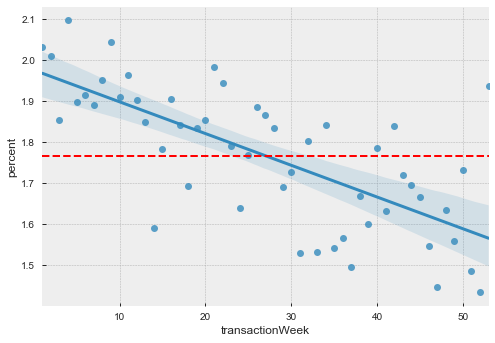

In [74]:
#plot
ax = sns.regplot(x=group, y='percent', data=df_analysis)
ax.axhline(avg_daily_fraud_percentage, ls='--', c='r')


ax.set_xlabel('transactionWeek')
print("Transaction fraud percent by week")

We see here a clear trend that fraudulent transactions per weel are decreasing over time, from around 2% of transactions at the start of the year to 1.6% towards the end. If we wish to shuffle the data, we'll need to add a variable to quantify this, such as the month, or the week of the year. 



### Check for variations across country

In [75]:
# does fraud happen equally across each country?
group = 'acqCountry'
target = 'isFraud'
# distill the above concept into a callable imported from the notebook_utilities module 
df_plot = calculate_target_percentage_by_group(df, group, target, filter_true=True)
df_plot

,acqCountry,isFraud,count,total,percent
1,CAN,True,50,1870,2.673797
5,PR,True,32,1202,2.662230
3,MEX,True,58,2626,2.208682
7,US,True,11026,632303,1.743784


Text(0.5, 6.799999999999994, 'acqCountry, isFraud == True')

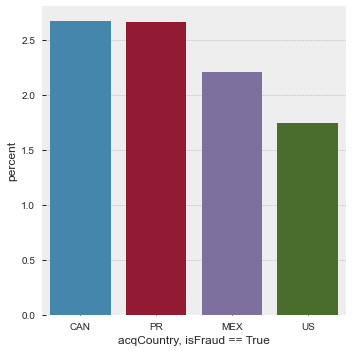

In [76]:
g = sns.catplot(x=x, y='percent', kind='bar', data=df_plot)
g.ax.set_xlabel('acqCountry, isFraud == True')

### Check for variance across merchantName

In [78]:
group, target = 'merchantName', 'isFraud'

# distill the above concept into a callable imported from the notebook_utilities module 
df_plot = calculate_target_percentage_by_group(df, group, target, filter_true=True)
df_plot.head()

,merchantName,isFraud,count,total,percent
1415,Hyatt House #786719,True,18,92,19.565217
1409,Hyatt House #691218,True,19,108,17.592593
941,Fast Repair,True,90,523,17.208413
3736,Walgreens #856780,True,3,19,15.789474
1405,Hyatt House #686333,True,11,82,13.414634


In [79]:
df_plot.tail(5)

,merchantName,isFraud,count,total,percent
288,Bobs Furniture,True,2,514,0.389105
538,Convenient Tire,True,2,541,0.369686
943,Fast Tire,True,1,481,0.207900
3933,West Elm,True,1,515,0.194175
2295,Pottery Barn,True,1,553,0.180832


In [80]:
df_plot.describe()

,count,total,percent
count,1522.000000,1522.000000,1522.000000
mean,7.425756,357.127464,2.683946
std,34.835031,1567.085274,2.107607
min,1.000000,15.000000,0.180832
25%,1.000000,79.000000,1.204819
50%,2.000000,89.000000,2.197802
75%,3.000000,102.000000,3.428230
max,575.000000,25311.000000,19.565217


total number of merchantNames: 1522


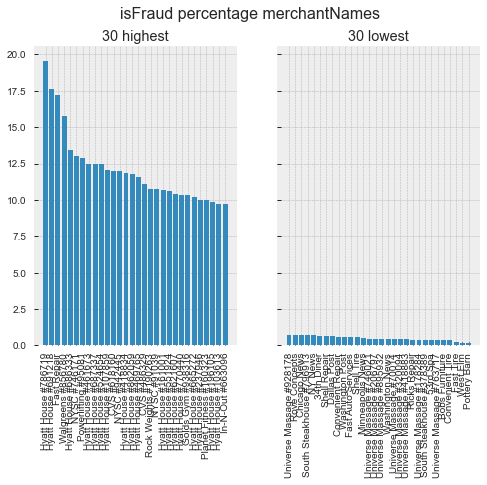

In [83]:
n = 30  # number of bars to plot 

fig, axes = plt.subplots(ncols=2, sharey=True)
fig.suptitle('isFraud percentage merchantNames', fontsize=16)

axes[0].set_title("30 highest")
axes[0].bar(df_plot.head(n)[group], df_plot.head(n)['percent'])
axes[0].set_xticklabels(df_plot.head(n)[group], rotation=90)
axes[1].set_title("30 lowest")
axes[1].bar(df_plot.tail(n)[group], df_plot.tail(n)['percent'])

axes[1].set_xticklabels(df_plot.tail(n)[group], rotation=90)

print(f"total number of merchantNames: {len(df_plot)}")

The above gives us an indication that certain merchants may be more likely to have fraudulent transactions, however we should do more analysis before we can concluce this is statistically unexpected


1) It is expected due to random variation that some merchants will be higher than others. 

   * If each merchant has an equal chance of fraud, we'd expect to see a normal distribution
   
2) What if the percentage is high with some retailers because the number of transactions is small?
 
   * Let's see if the relationship holds when we filter for small total transactions per merchant
   
   
3) Does the relationship hold consistently over time? 

   * With more time, we'd investigate this by ranking stores by % fraud each month and see how consistent the rank correlation is
   
 
 4) We see that certain chain stores occur more than others. 
 
   * Is the relationship present for entire chains, or for their individual outlets? 
   

Text(0.5, 1.0, '% fraudulent transactions by merchant distribution')

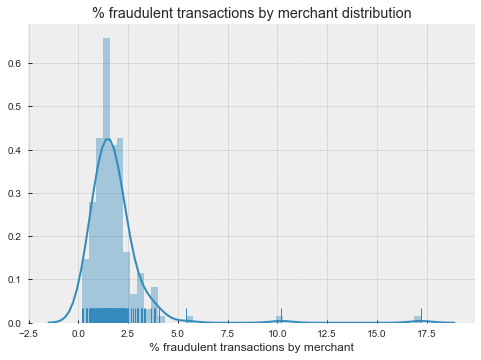

In [96]:
# 1) view the distribution to see if it's normally distributed

g = sns.distplot(df_plot['percent_isFraudTrue'], kde=True, rug=True)
g.set_xlabel('% fraudulent transactions by merchant')
plt.title('% fraudulent transactions by merchant distribution')

Normally distributed for most merchants but a clear skew to the right - some merchants have considerably higher than average % fraudulent transactions.
Possibly a chi-squared distribution 

\* (with more time, we could quantify this with a statistical test)



### Check when we aggregate merchantName chains together 


In [86]:
# take the all of a merchantName before the last # and replot
df_copy = df.copy()
df_copy['merchantName'] = df['merchantName'].apply(lambda row: row.split('#')[0])

df_copy['merchantName'][df['merchantName'].str.contains('#')]

7         Universe Massage 
8         Universe Massage 
9         Universe Massage 
17        Universe Massage 
18                Hardee's 
                ...        
641826           Shell Gas 
641835           Shell Gas 
641838           Shell Gas 
641848           Shell Gas 
641852           Shell Gas 
Name: merchantName, Length: 287613, dtype: object

total number of unique merchantNames: 175


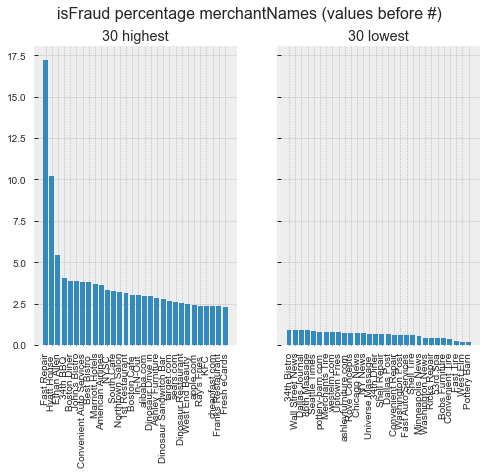

In [87]:
group, target = 'merchantName', 'isFraud'

# callable imported from the notebook_utilities module 
df_plot = calculate_target_percentage_by_group(df_copy, group, target, filter_true=True)
df_plot.head()


n = 30  # number of bars to plot 

fig, axes = plt.subplots(ncols=2, sharey=True)
fig.suptitle('isFraud percentage merchantNames (values before #)', fontsize=16)


axes[0].set_title("30 highest")
axes[0].bar(df_plot.head(n)[group], df_plot.head(n)['percent'])
axes[0].set_xticklabels(df_plot.head(n)[group], rotation=90)
axes[1].set_title("30 lowest")
axes[1].bar(df_plot.tail(n)[group], df_plot.tail(n)['percent'])

axes[1].set_xticklabels(df_plot.tail(n)[group], rotation=90)

print(f"total number of unique merchantNames: {len(df_plot)}")

Text(0.5, 1.0, '% fraudulent transactions by merchant distribution')

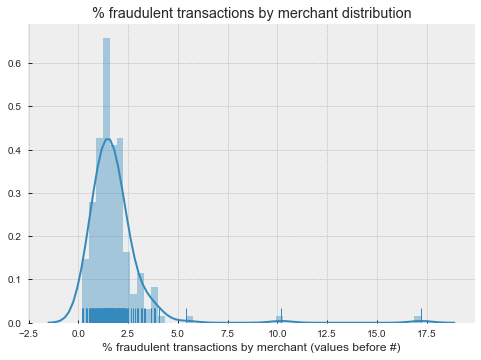

In [89]:
g = sns.distplot(df_plot['percent'], kde=True, rug=True)
g.set_xlabel('% fraudulent transactions by merchant (values before #)')
plt.title('% fraudulent transactions by merchant distribution')

### Card CVV Analysis 

Let's see if there's any correlation between the card CVV and the entered CVV

Hypothesis: if it's entered incorrectly, it's more likely to be fraudulent

In [92]:
df_analysis = df.copy()

# identify where the enteredCVV is different
df_analysis['diff'] = df_analysis[['enteredCVV', 'cardCVV']].apply(lambda row: 'different' if row['enteredCVV'] != row['cardCVV'] else 'same', axis=1)

In [93]:
df_analysis['diff'].value_counts()

group, target = 'diff', 'isFraud'

df_plot = calculate_target_percentage_by_group(df_analysis, group, target, filter_true=True)
df_plot.head()

,diff,isFraud,count,total,percent
1,different,True,195,5937,3.284487
3,same,True,11107,635977,1.746447


Our hypothesis holds weight, we're ~2x as likely to be fraudulent if the CVV is entered incorrectly  

### Examine the distribution of fraud per account

In [ ]:
group, target = 'accountNumber', 'isFraud' 
df_analysis = calculate_target_percentage_by_group(df, group, target, filter_true=True)
df_analysis.head()

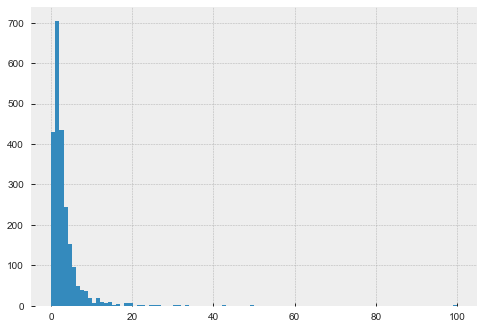

In [23]:
df_analysis['percent'].hist(bins=100)

The majority of accounts have low incidences of fraud but some accounts clearly have more than expected and appear more prone to fraud

### Examine the significance of values at the end of numerical features

Hypothesis: the last digit of eg transaction amounts is more likely to be some digits than others in fraudulent transactions (perhaps those committing fraud will try and avoid .00 transactions for example)

In [95]:
# get the 'pence' of the transactionAmount to see if some 'pences' show up more than others in fraudulent transactions
df_analysis['transactionAmount_pence'] = df['transactionAmount'].apply(lambda row: int(math.modf(row)[0]*100))

In [98]:
group, target = 'transactionAmount_pence', 'isFraud'

df_plot = calculate_target_percentage_by_group(df_analysis, group, target, filter_true=True)
df_plot.head()

,transactionAmount_pence,isFraud,count,total,percent
0,0,False,28554,28848,98.980865
120,60,False,6346,6420,98.847352
146,73,False,5701,5770,98.804159
184,92,False,6856,6939,98.803862
170,85,False,6374,6453,98.775763


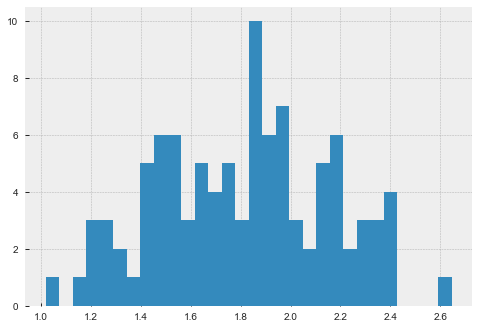

In [97]:
df_plot['percent'].hist(bins=30)

Let's do the same for the other numeric columns to see if anything looks unusual

In [ ]:
# get the 'pence' of the transactionAmount to see if some 'pences' show up more than others in fraudulent transactions
df_analysis['transactionAmount_pence'] = df['transactionAmount'].apply(lambda row: int(math.modf(row)[0]*100))

In [123]:
dist_t = df_analysis['transactionAmount_pence'][df_analysis['isFraud'] == True].value_counts(normalize=True).mul(100).sort_index()
dist_f = df_analysis['transactionAmount_pence'][df_analysis['isFraud'] == False].value_counts(normalize=True).mul(100).sort_index()
dist_t

0     2.601310
1     0.937887
2     0.796319
3     1.185631
4     0.893647
        ...   
95    0.867103
96    1.141391
97    0.840559
98    0.734383
99    0.902495
Name: transactionAmount_pence, Length: 100, dtype: float64

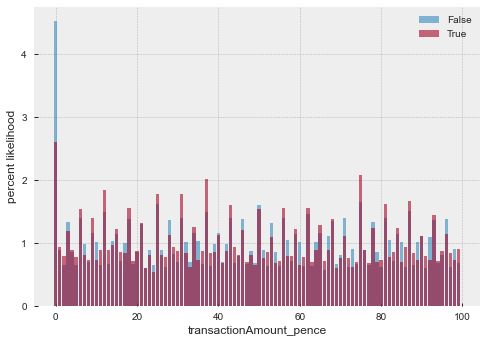

In [147]:
plt.bar(dist_f.index, dist_f, label='False', alpha = 0.6)
plt.bar(dist_t.index, dist_t, label='True', alpha = 0.6)
plt.ylabel('percent likelihood')
plt.xlabel('transactionAmount_pence')
plt.legend()

This is very interesting! It seems fraudulent transactions are __considerably less likely__ to have .00 than real transactions. Let's see if we see the same behaviour in currentBalance or availableMoney

In [146]:
# distill the above into a function that can be used for the other variables 
def plot_pence_distribution(df, variable):
    df_analysis = df.copy()
    df_analysis[variable+'_pence'] = df[variable].apply(lambda row: int(math.modf(row)[0]*100))
    dist_t = df_analysis[variable+'_pence'][df_analysis['isFraud'] == True].value_counts(normalize=True).mul(100).sort_index()
    dist_f = df_analysis[variable+'_pence'][df_analysis['isFraud'] == False].value_counts(normalize=True).mul(100).sort_index()

    plt.bar(dist_f.index, dist_f, label='False', alpha = 0.6)
    plt.bar(dist_t.index, dist_t, label='True', alpha = 0.6)
    plt.ylabel('percent likelihood')
    plt.xlabel(variable+'_pence')
    plt.legend()

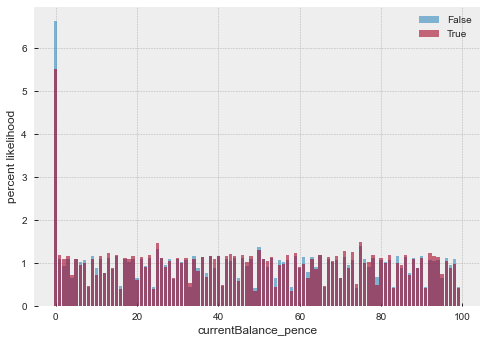

In [149]:
plot_pence_distribution(df, 'currentBalance')

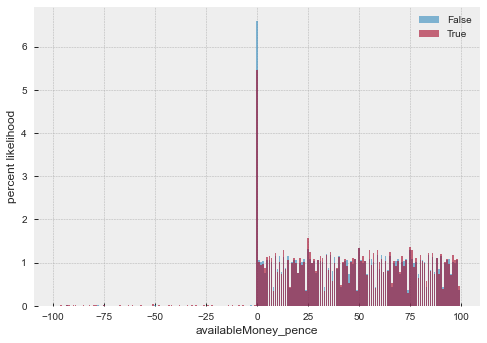

In [150]:
plot_pence_distribution(df, 'availableMoney')

The effect is observable here also but not as significant as in transactionAmount

### End

We'll use the insights we've gained here to develop features in the modelling phase